In [17]:
import numpy as np
import pandas as pd
from scipy import sparse

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import diffusion_dist as diff

import matplotlib.pyplot as plt

from sklearn import decomposition, preprocessing
from torch.utils.data import Dataset, DataLoader

import model.autoencoder as ae

from dataset import *

from utils import *
from model.loss import *
from diffusion_dist import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import phate

In [2]:
import numpy as np
import random
import pandas as pd
import warnings
import scipy

warnings.filterwarnings('ignore')

In [18]:
symsim_r1b1 = hhRNA1(standardize=False, rna_seq_file = "./data/human_hematopoiesis/count_rna.csv", rna_celltype_file = "./data/human_hematopoiesis/celltypes_rna.txt")
symsim_r1b2 = hhATAC1(standardize=False, atac_seq_file = "./data/human_hematopoiesis/count_atac.csv", atac_celltype_file = "./data/human_hematopoiesis/celltypes_atac.txt")

symsim_r1b1_CONFIG = { 
    'in_features': 500,
    'layers': [512, 256, 128, 2], # number of nodes in each layer of encoder and decoder.
    'minibatch_size': 256, # batch size need to be large enough to represent the population
    'use_batchnorm': True, # use batch normalization layer.
    'use_tanh': False, # tanh before latent visualization.
}

symsim_r1b2_CONFIG = { 
    'in_features': 1764,
    'layers': [512, 256, 128, 2], # number of nodes in each layer of encoder and decoder.
    'minibatch_size': 256,
    'use_batchnorm': True, # use batch normalization layer.
    'use_tanh': False, # tanh before latent visualization.
}

train_r1b1_loader = DataLoader(symsim_r1b1, batch_size = symsim_r1b1_CONFIG["minibatch_size"], shuffle = True)
train_r1b2_loader = DataLoader(symsim_r1b2, batch_size = symsim_r1b1_CONFIG["minibatch_size"], shuffle = True)
test_r1b1_loader = DataLoader(symsim_r1b1, batch_size = len(symsim_r1b1), shuffle = False)
test_r1b2_loader = DataLoader(symsim_r1b2, batch_size = len(symsim_r1b2), shuffle = False)

for data in test_r1b1_loader:
    _, Diff1 = phate_similarity(data["raw"], 
                                  # control radius with decay
                                  n_neigh = 5, 
                                  t = 15, 
                                  use_potential = True, 
                                  # control radius with decay, if thresh equals to 0, the decaying of the kernel function is still calculated adaptively, with the equation np.exp(-1 * np.power(pdx, self.decay)) and pdx = (pdx.T / dist_kth).T
                                  thresh = 0,
                                  # decay gets larger, the radius get smaller, when decay gets infinity, the radius equals to the exact kth neighbor distance: radius = dist_kth * np.power(-1 * np.log(thresh),1/decay), the node outside the distance will be not connected
                                  # decay gets smaller, can be efficient
                                  decay = 40)

    
    Diff1 = torch.FloatTensor(Diff1).to(device)
    X_phate1 = phate.PHATE(n_components=2).fit_transform(data["raw"].numpy())


    

for data in test_r1b2_loader:
    _, Diff2 = phate_similarity(data["raw"], 
                                  n_neigh = 5, 
                                  t = 70, 
                                  use_potential = True,
                                  thresh = 0,
                                  decay = 10)


      
    
    Diff2 = torch.FloatTensor(Diff2).to(device)
    X_phate2 = phate.PHATE(n_components=2).fit_transform(data["raw"].numpy())

Calculating PHATE...
  Running PHATE on 1666 observations and 500 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.07 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.29 seconds.
    Calculating affinities...
    Calculated affinities in 0.08 seconds.
  Calculated graph and diffusion operator in 0.45 seconds.
  Calculating optimal t...
    Automatically selected t = 12
  Calculated optimal t in 11.71 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.21 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 4.84 seconds.
Calculated PHATE in 17.23 seconds.
Calculating PHATE...
  Running PHATE on 1011 observations and 1764 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.10 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.11 seconds.
    Calculating affinities...
    Calculated affinities in 0.01 

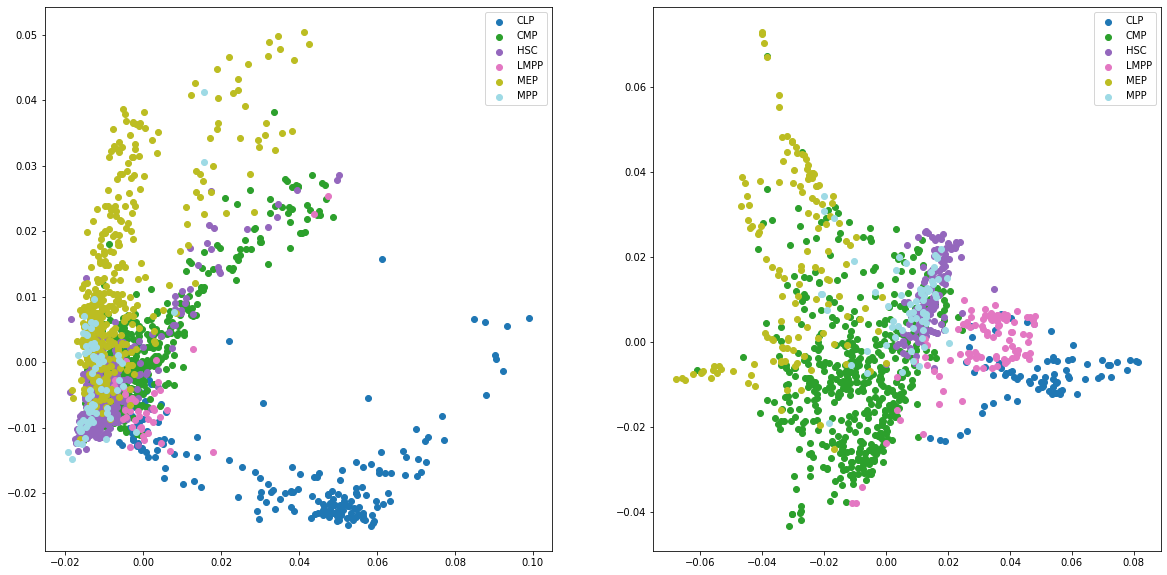

In [22]:
plot_latent(z1 = X_phate1, z2 = X_phate2, anno1 = symsim_r1b1.cell_labels, anno2 = symsim_r1b2.cell_labels, mode = "separate",save = None)

In [24]:
from collections import OrderedDict

ae1 = nn.Sequential(OrderedDict([
        ("encoder", ae.Encoder(symsim_r1b1_CONFIG)), 
        ("decoder", ae.Decoder(symsim_r1b1_CONFIG))
      ])).to(device)

ae2 = nn.Sequential(OrderedDict([
        ("encoder", ae.Encoder(symsim_r1b2_CONFIG)), 
        ("decoder", ae.Decoder(symsim_r1b2_CONFIG))
      ])).to(device)

disc = ae.discriminator(hidden1 = 64, hidden2 = 32, hidden3 = 1).to(device)

optimizer_rna = torch.optim.Adam(ae1.parameters(), lr = 1e-3)
optimizer_atac = torch.optim.Adam(ae2.parameters(), lr = 1e-3)
optimizer_D = torch.optim.Adam(disc.parameters(), lr = 1e-3)

In [25]:
train_unpaired(ae1, ae2, disc, train_r1b1_loader, train_r1b2_loader, Diff1, Diff2, optimizer_rna, optimizer_atac, optimizer_D, n_epochs=101, lamb_r_atac = 0,
 lamb_r_rna = 0, lamb_disc = 0, n_iter = 15, dist_mode = "mse")

epoch:  0 RNA loss: 0.24332, RNA recon loss: 0.00000, RNA dist loss: 0.24332 ATAC loss: 0.15017, ATAC recon loss: 0.00000, ATAC dist loss: 0.15017 Discriminator loss: 0.00000
epoch:  10 RNA loss: 0.09333, RNA recon loss: 0.00000, RNA dist loss: 0.09333 ATAC loss: 0.11889, ATAC recon loss: 0.00000, ATAC dist loss: 0.11889 Discriminator loss: 0.00000
epoch:  20 RNA loss: 0.09251, RNA recon loss: 0.00000, RNA dist loss: 0.09251 ATAC loss: 0.07556, ATAC recon loss: 0.00000, ATAC dist loss: 0.07556 Discriminator loss: 0.00000
epoch:  30 RNA loss: 0.07462, RNA recon loss: 0.00000, RNA dist loss: 0.07462 ATAC loss: 0.05325, ATAC recon loss: 0.00000, ATAC dist loss: 0.05325 Discriminator loss: 0.00000
epoch:  40 RNA loss: 0.08496, RNA recon loss: 0.00000, RNA dist loss: 0.08496 ATAC loss: 0.03894, ATAC recon loss: 0.00000, ATAC dist loss: 0.03894 Discriminator loss: 0.00000
epoch:  50 RNA loss: 0.08956, RNA recon loss: 0.00000, RNA dist loss: 0.08956 ATAC loss: 0.04649, ATAC recon loss: 0.0000

In [ ]:
# state = torch.load('./saved_model/hm_new1.pt')

# ae1 = nn.Sequential(OrderedDict([
#         ("encoder", ae.Encoder(symsim_r1b1_CONFIG)), 
#         ("decoder", ae.Decoder(symsim_r1b1_CONFIG))
#       ])).to(device)
# ae1.load_state_dict(state['ae1'])

# ae2 = nn.Sequential(OrderedDict([
#         ("encoder", ae.Encoder(symsim_r1b2_CONFIG)), 
#         ("decoder", ae.Decoder(symsim_r1b2_CONFIG))
#       ])).to(device)
# ae2.load_state_dict(state['ae2'])

# disc = ae.discriminator().to(device)

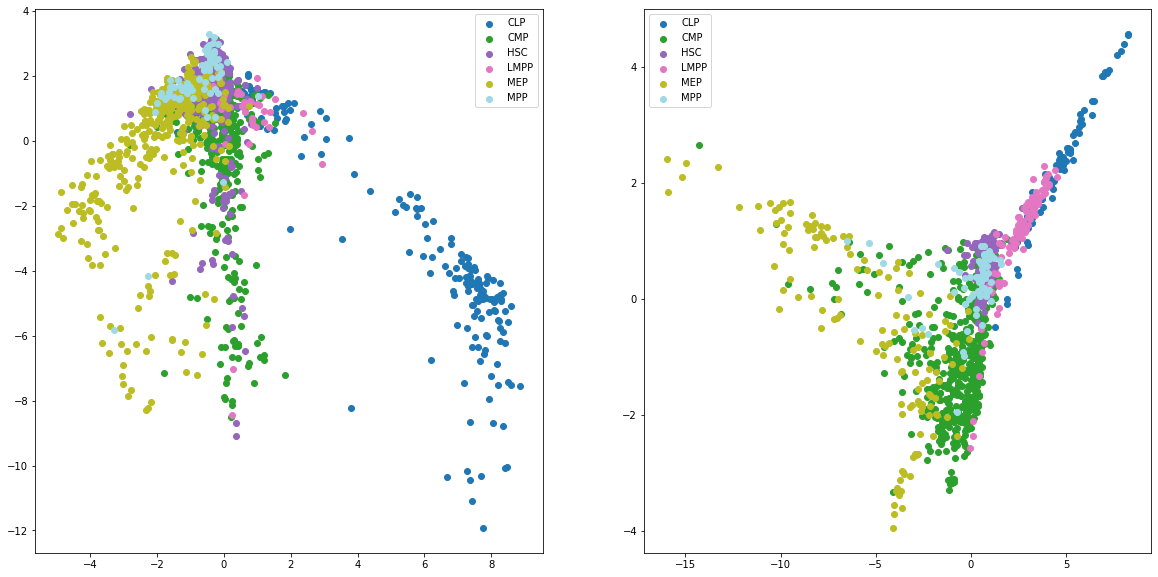

In [15]:
# ATAC radius small n_neigh = 5, decay = 10, thresh = 0, t = 25 the best
ae1.eval()
ae2.eval()

for data in test_r1b1_loader:
    ae_coordinates1 = ae1[:1](data['count'].to(device)).cpu().detach().numpy()

for data in test_r1b2_loader:
    ae_coordinates2 = ae2[:1](data['count'].to(device)).cpu().detach().numpy()

# plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = symsim_r1b1.cell_labels, anno2 = symsim_r1b2.cell_labels, mode = "joint",save = "./result/hm/new/2/joint.pdf")
plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = symsim_r1b1.cell_labels, anno2 = symsim_r1b2.cell_labels, mode = "separate",save = "./result/test_distance/hm_large_t_mse.pdf")

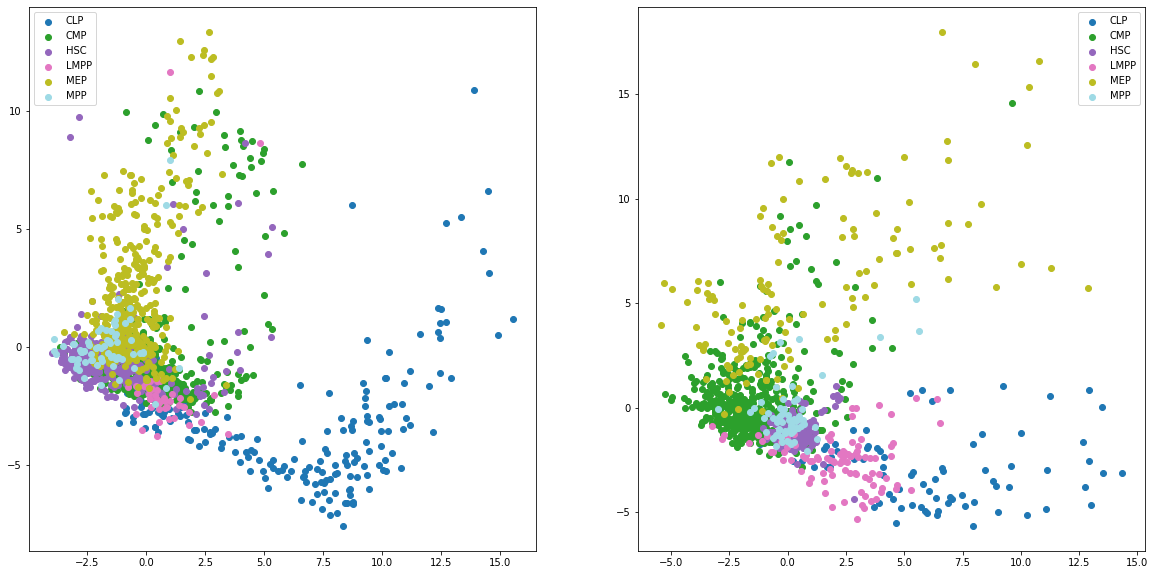

In [43]:
# plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = symsim_r1b1.cell_labels, anno2 = symsim_r1b2.cell_labels, mode = "separate",save = "./result/hm/new/2/separate.pdf")
plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = symsim_r1b1.cell_labels, anno2 = symsim_r1b2.cell_labels, mode = "separate",save = None)

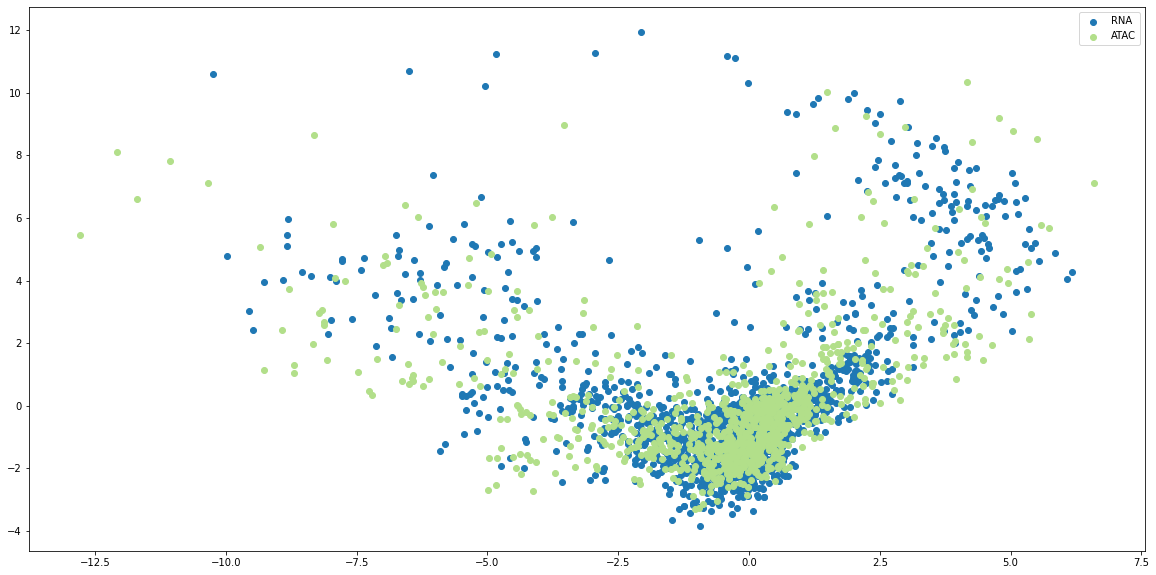

In [27]:
# plot_latent(z1 = ae_coordinates1, z2 = ae_coordinates2, anno1 = symsim_r1b1.cell_labels, anno2 = symsim_r1b2.cell_labels, mode = "modality",save = "./result/hm/new/2/modality.pdf")

In [22]:
torch.save({
    'ae1': ae1.state_dict(),
    'optim_ae1': optimizer_rna.state_dict(),
    'ae2': ae2.state_dict(),
    'optim_ae2': optimizer_rna.state_dict(),
    'disc': disc.state_dict(),
    'optim_disc': optimizer_D.state_dict(),
    'config1': symsim_r1b1_CONFIG,
    'config2': symsim_r1b2_CONFIG,
    'Diff1': Diff1,
    'Diff2': Diff2,
}, './saved_model/hm_new2.pt')